In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
path = '/Users/albenvinoj/Files/ThoughtWorks'
os.chdir(path)

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('trainingData.csv')
train.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,...,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [3]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
social_class,5255,13.14
water_availabity,5253,13.13
secondary_business,5241,13.10
city,1864,4.66
type_of_house,694,1.74
home_ownership,379,0.95
sanitary_availability,208,0.52
monthly_expenses,120,0.30
loan_purpose,26,0.06
primary_business,26,0.06


In [4]:
previous_train = train.copy()
train.drop(columns=['Id'],axis=1, inplace=True)

In [5]:
## Handling Missing Values

missing_val_col = ["social_class", 
                   "secondary_business", 
                   "city",
                   "type_of_house",
                   "loan_purpose",
                   "primary_business"]

for i in missing_val_col:
    train[i] = train[i].fillna('None')

In [6]:
## These features are numerical variable, we used "0" to replace the null values. 
missing_val_col2 = ['home_ownership',
                    'water_availabity',
                    'sanitary_availability']

for i in missing_val_col2:
    train[i] = train[i].fillna(0)

In [7]:
## replacing annual income missing values with mean


train['monthly_expenses'] = train['monthly_expenses'].transform( lambda x: x.fillna(x.mean()))

In [8]:
missing_percentage(train)

,Total,Percent


In [9]:
# Treating Outliers

def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (15,10))
    fig = sns.scatterplot(y = y, x = x);

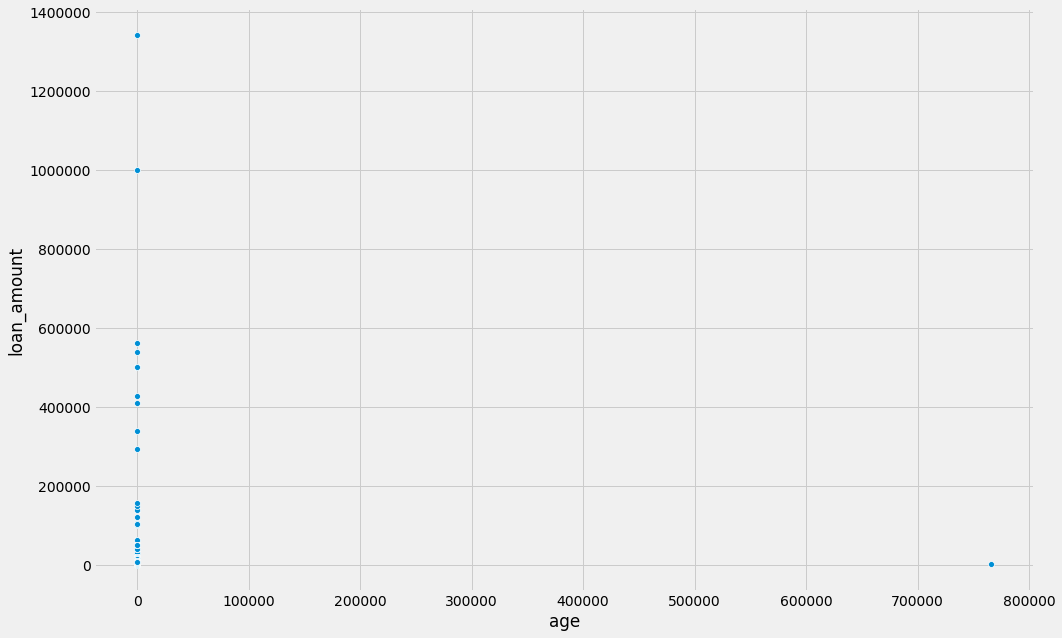

In [10]:
customized_scatterplot(train.loan_amount, train.age)

In [11]:
train = train[train.loan_amount < 20000]
train.reset_index(drop = True, inplace = True)

In [12]:
train = train[train.age < 80]
train.reset_index(drop = True, inplace = True)

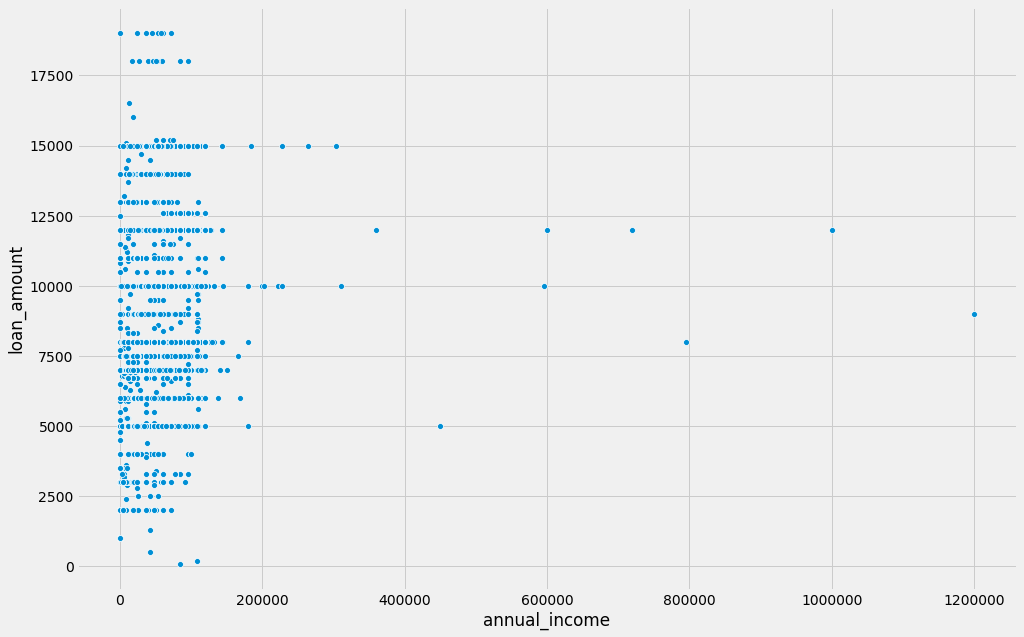

In [13]:
customized_scatterplot(train.loan_amount, train.annual_income)

In [14]:
train = train[train.annual_income < 200000]
train.reset_index(drop = True, inplace = True)

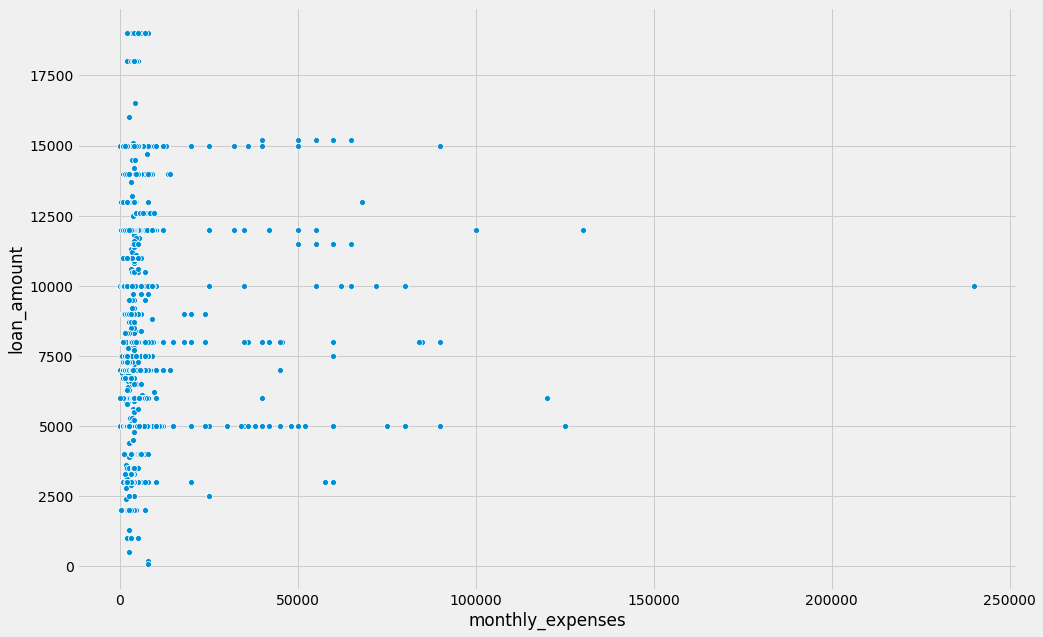

In [15]:
customized_scatterplot(train.loan_amount, train.monthly_expenses)

In [16]:
train = train[train.monthly_expenses < 75000]
train.reset_index(drop = True, inplace = True)

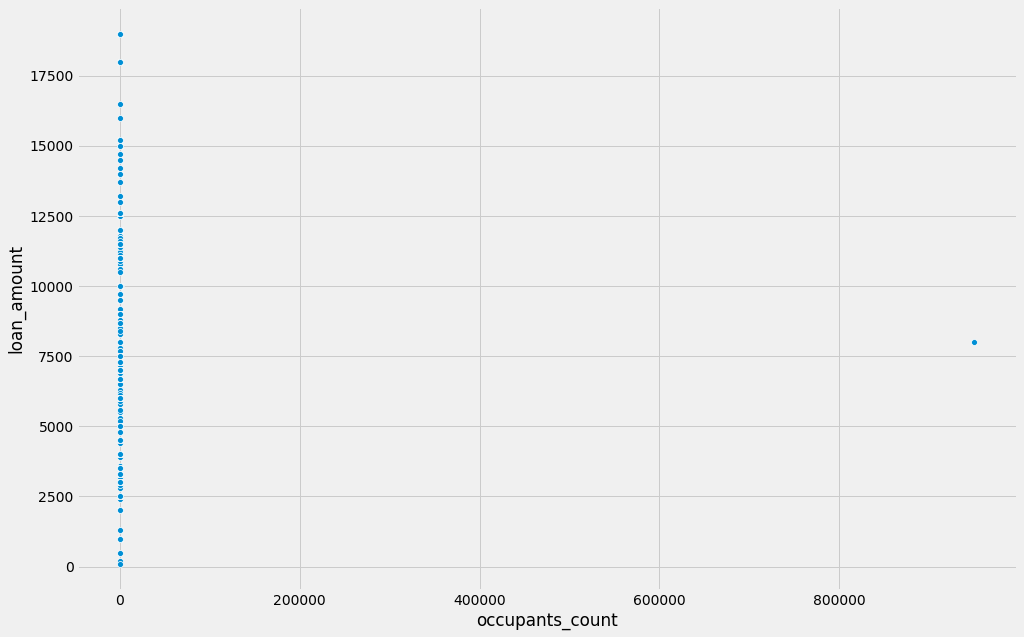

In [17]:
customized_scatterplot(train.loan_amount, train.occupants_count)

In [18]:
train = train[train.occupants_count < 11]
train.reset_index(drop = True, inplace = True)

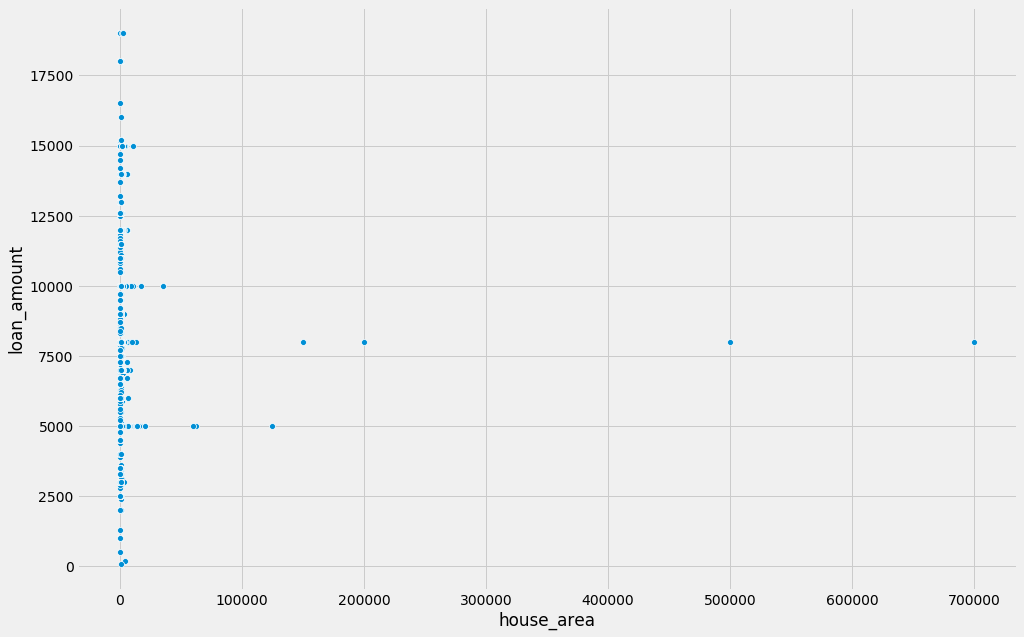

In [19]:
customized_scatterplot(train.loan_amount, train.house_area)

In [20]:
train = train[train.house_area < 6001]
train.reset_index(drop = True, inplace = True)

In [21]:
train.loc[train.water_availabity < 0, 'water_availabity'] = 0
train.loc[train.sanitary_availability < 0, 'sanitary_availability'] = 0

In [22]:
train.describe()

,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availabity,loan_tenure,loan_installments,loan_amount
count,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000,39703.000000
mean,36.000479,37226.946150,3749.215426,0.044430,1.134121,0.963655,2.723119,490.307282,0.681561,0.652973,12.009798,21.801400,8065.516460
std,8.924090,25937.891683,3895.321774,0.220574,1.071999,0.187149,1.560827,501.230811,0.465877,0.348546,1.053182,16.701795,2984.331738
min,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,100.000000
25%,29.000000,14400.000000,2500.000000,0.000000,0.000000,1.000000,2.000000,200.000000,0.000000,0.500000,12.000000,12.000000,5000.000000
50%,35.000000,36000.000000,3500.000000,0.000000,1.000000,1.000000,3.000000,400.000000,1.000000,0.500000,12.000000,12.000000,8000.000000
75%,42.000000,55200.000000,4000.000000,0.000000,2.000000,1.000000,4.000000,600.000000,1.000000,1.000000,12.000000,50.000000,10000.000000
max,75.000000,184000.000000,72000.000000,3.000000,7.000000,1.000000,10.000000,6000.000000,1.000000,1.000000,24.000000,74.000000,19000.000000


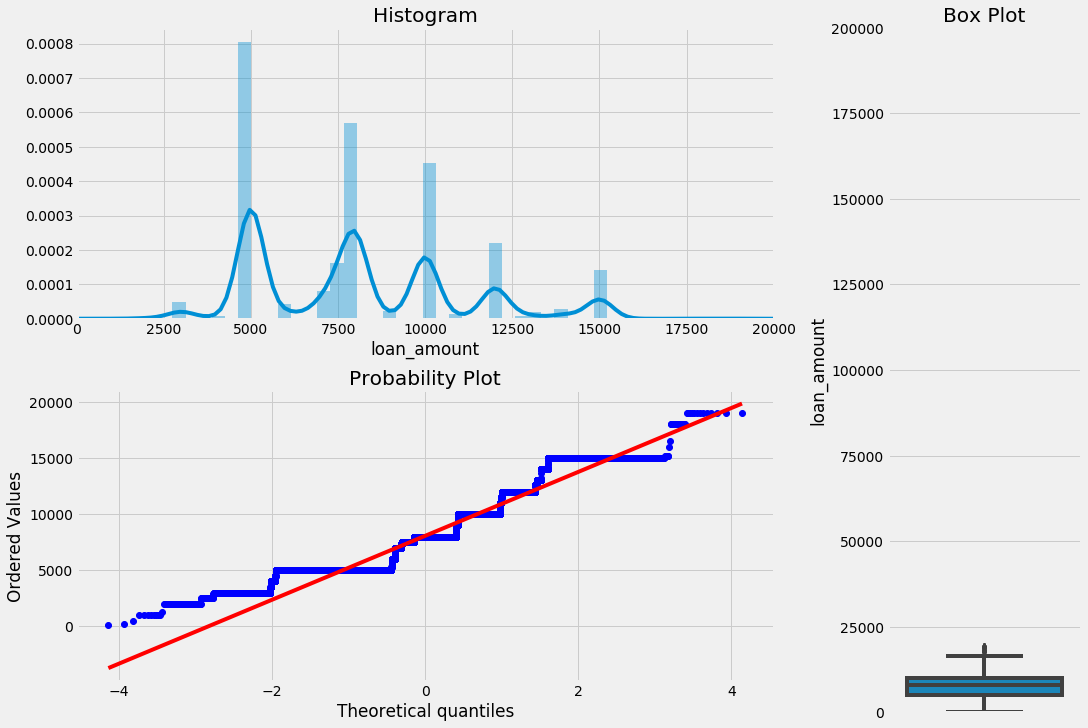

In [23]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    fig1 = sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)
    fig1.axis(xmin=0, xmax=20000);
    
    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    fig2 = sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    fig2.axis(ymin=0, ymax=200000);
   
plotting_3_chart(train, 'loan_amount')

In [24]:
print("Skewness: " + str(train['loan_amount'].skew()))
print("Kurtosis: " + str(train['loan_amount'].kurt()))

Skewness: 0.6149256845960651
Kurtosis: -0.24086196200950338


In [25]:
train['dependents'] = train['old_dependents'] + train['young_dependents']

In [26]:
train = train.drop(['old_dependents', 'young_dependents', 'primary_business',], axis=1)

In [27]:
## Getting the correlation of all numeric features with target variable. 
(all_data.corr())["loan_amount"].sort_values(ascending = False)[1:15]

NameError: name 'all_data' is not defined

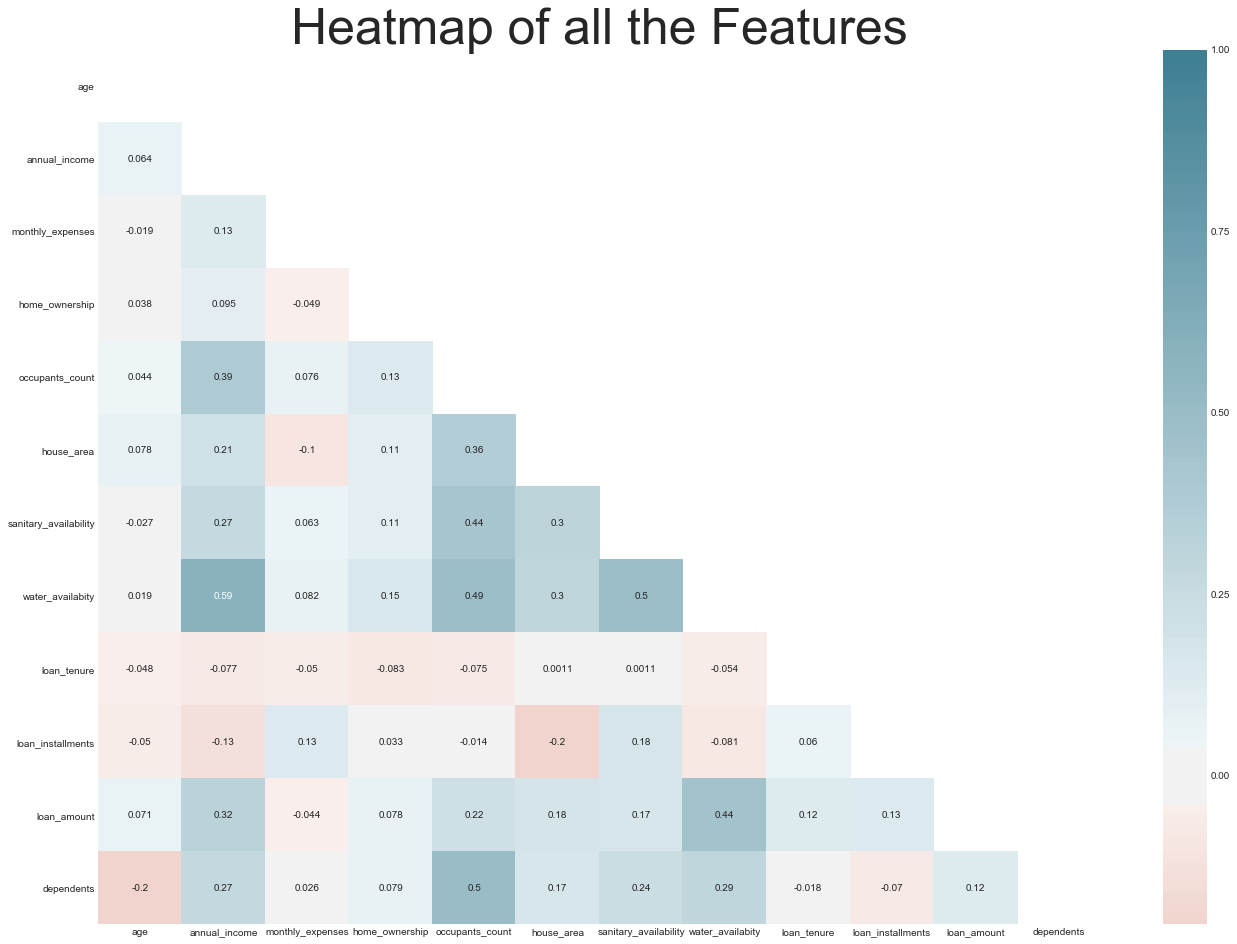

In [28]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 50);

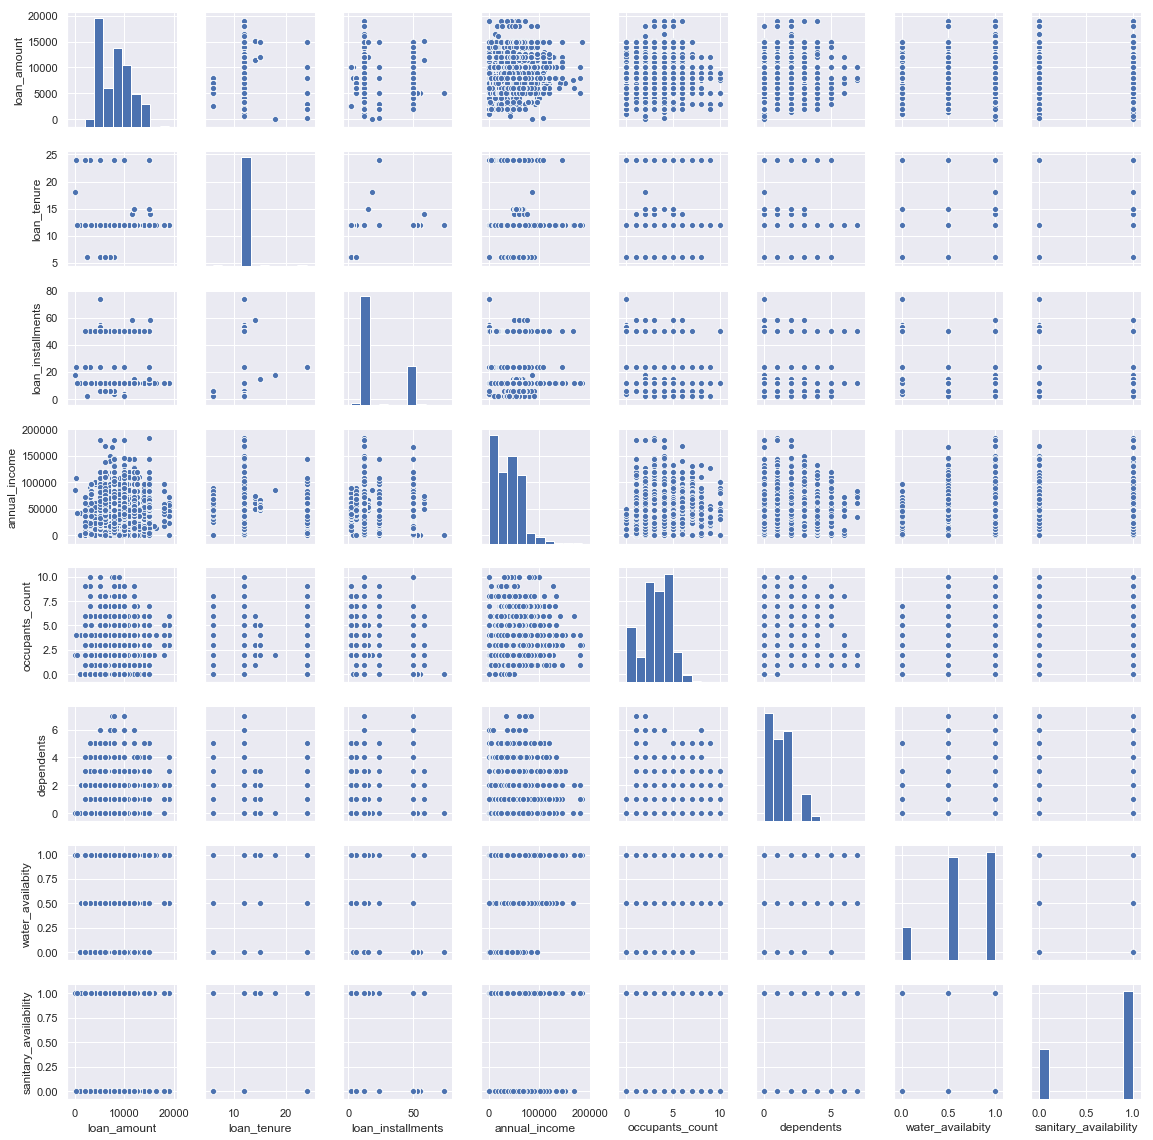

In [29]:
sns.set()
cols = ['loan_amount', 'loan_tenure','loan_installments','annual_income', 'occupants_count', 'dependents', 'water_availabity', 'sanitary_availability']
sns.pairplot(train[cols], size = 2)
plt.show();

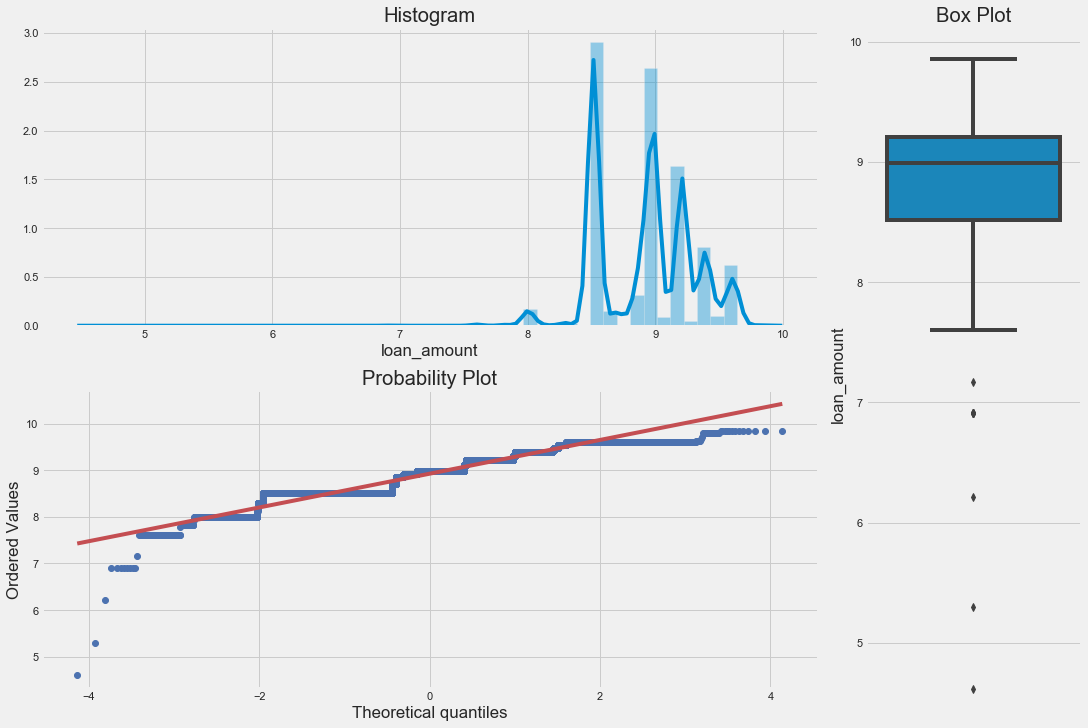

In [30]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    fig1 = sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)
    #fig1.axis(xmin=0, xmax=20000);
    
    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    fig2 = sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    #fig2.axis(ymin=0, ymax=200000);
    
## Plotting the newly transformed response variable
train["loan_amount"] = np.log1p(train["loan_amount"])
plotting_3_chart(train, 'loan_amount')

In [31]:
## Loan Tenure and Installments are given in numerical; therefore converted to categorical variables. 
train['loan_tenure'] = train['loan_tenure'].astype(str)
train['loan_installments'] = train['loan_installments'].astype(str)

In [32]:
y = train['loan_amount'].reset_index(drop=True)

In [33]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

monthly_expenses         11.986265
house_area                3.446548
dependents                0.576328
annual_income             0.395592
age                       0.288083
occupants_count          -0.069696
loan_amount              -0.217603
water_availabity         -0.498014
sanitary_availability    -0.779446
home_ownership           -4.954990
dtype: float64

In [34]:
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(train)

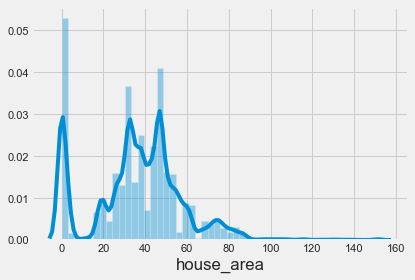

In [35]:
sns.distplot(train['house_area']);

In [36]:
train.head()

,city,age,sex,social_class,secondary_business,annual_income,monthly_expenses,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount,dependents
0,Dhanbad,22,F,Mochi,Others,36000.0,9.073611,35.011336,R,4,14.808862,41.590267,0.5,Apparels,12,12,8.517393,1.710902
1,Manjapra,21,F,OBC,none,94000.0,8.702273,35.011336,T1,4,15.951443,41.590267,0.5,Apparels,12,50,8.922792,1.710902
2,Dhanbad,24,M,Nai,Others,48000.0,8.821173,35.011336,T1,4,12.250281,41.590267,0.5,Beauty Salon,12,12,8.517393,1.710902
3,None,26,F,OBC,none,7000.0,9.073611,35.011336,T1,5,12.250281,41.590267,0.5,Apparels,12,50,8.922792,1.710902
4,Nuapada,23,F,OBC,Agriculture,36000.0,8.670514,35.011336,T1,1,19.196398,41.590267,0.5,Retail Store,12,12,8.517393,0.000000


In [37]:
train.shape

(39703, 18)

In [38]:
all_data = train.copy()

In [39]:
all_data.drop(['loan_amount'], axis = 1, inplace = True)

In [40]:
all_data.shape

(39703, 17)

In [41]:
all_data = pd.get_dummies(all_data).reset_index(drop=True)
all_data.shape

(39703, 1401)

In [42]:
all_data.to_csv("lm_train.csv", index=False)

In [43]:
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(all_data,y,test_size = .30, random_state = 0)

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27792, 1401), (27792,), (11911, 1401), (11911,))

In [45]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
# make predictions
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Mean Absolute Error : " + str(mean_absolute_error(np.expm1(predictions), np.expm1(y_test))))
print("Mean Squared Error : " + str(mean_squared_error(np.expm1(predictions), np.expm1(y_test))))
print("R Square : " + str(r2_score(np.expm1(predictions), np.expm1(y_test))))

Mean Absolute Error : 1598.23605713321
Mean Squared Error : 4673913.139802353
R Square : -0.6323387921480488


In [120]:
np.expm1(predictions)

array([6211.151 , 8627.757 , 9221.384 , ..., 6961.0312, 8692.133 ,
       9202.599 ], dtype=float32)

In [50]:
rmse = np.sqrt(mean_squared_error(np.expm1(predictions), np.expm1(y_test)))
print('RMSE: %f' % rmse)

RMSE: 2161.923481


In [ ]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

In [ ]:
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Mean Absolute Error : " + str(mean_absolute_error(np.expm1(predictions), np.expm1(y_test))))
print("Mean Squared Error : " + str(mean_squared_error(np.expm1(predictions), np.expm1(y_test))))
print("R Square : " + str(r2_score(np.expm1(predictions), np.expm1(y_test))))